In [1]:
import matplotlib.pyplot as plt
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from itertools import combinations

In [3]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.ur10 import *
from pkg.geometry import *
from pkg.collision import *
from pkg.distance import *
from pkg.distance_calculator import *
from pkg.binding_calculator import *

# Load urdf 

In [4]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
urdf_content = URDF.from_xml_file(URDF_PATH)

In [5]:
link_names = LINK_NAMES
base_name = LINK_NAMES[0]
joint_names = JOINT_NAMES
link_info_list = get_link_info_list(link_names, urdf_content)

# Visualize

In [6]:
from pkg.ros_rviz import *
pub, joints, rate = get_publisher(JOINT_NAMES)

gitem_list, gframe_dict= get_link_items_offsets(color=(0,1,0,0.5), display=False)
gitem_list += [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0.3,0.3,0.8,1), display=True, collision=True),
    GeometryItem(name='floor', gtype=GeoType.PLANE, dims=[1,1,0.01], color=(0.6,0.6,0.6,1), display=True, collision=True)
]
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
marker_list = set_markers(gitem_list, gframe_dict, urdf_content)
show_motion([np.array([0]*6)], marker_list, 
            [[gframe_dict[mk.geometry.name] for mk in marker_list]], 
            pub, joints, error_skip=1e-6, period=1e-6)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK - tool_mesh
publication OK - box1
publication OK - floor


# Graph

In [7]:
from collections import defaultdict

In [8]:
class GraphModel(tf.keras.Model):
    def __init__(self, robot_info, gitem_list, binfo_list, urdf_content, N_sim, 
                 alpha_jc=5, alpha_fc=200, alpha_jl=1, alpha_cl=1,alpha_cs=0, dQ_max = tf.constant([[1.0]*6])*2e-1,
                 LIM=np.pi, LIM_BOUND=1e-1, COL_BOUND=1e-2, learning_rate=5e-3, col_iteration = 20):
        super(GraphModel, self).__init__()
        self.alpha_jc = alpha_jc
        self.alpha_fc = alpha_fc
        self.alpha_jl = alpha_jl
        self.alpha_cl = alpha_cl
        self.alpha_cs = alpha_cs
        self.N_sim = N_sim
        self.LIM = LIM
        self.LIM_BOUND = LIM_BOUND
        self.COL_BOUND = COL_BOUND
        self.dQ_max = tf.constant(dQ_max)
        self.learning_rate = learning_rate
        self.col_iteration = col_iteration
        self.robot_info = robot_info
        self.robot = RobotLayer(
            robot_info, dim=N_sim)
        self.joint_constraint = JointConstraintLoss(self.robot)
        self.frame_constraint = FrameConstraintLoss()
        self.robot_base = [robot_info.base_frame]*N_sim
        self.set_custom_loss(lambda *args: tf.constant(0.0), 0)
        self.link_name_list = self.robot.link_name_list
        self.link_idx_dict = self.robot.link_idx_dict
        self.adjacency_list = self.robot.adjacency_list
        self.dependency_list = self.robot.dependency_list
        self.dependency_mat = self.robot.dependency_mat
            
        self.object_dict = {}
        self.object_name_list = []
        for gitem in gitem_list:
            self.object_name_list += [gitem.name]
            self.object_dict[gitem.name] = ObjectLayer(gitem, N_sim, self.robot.num_link)
        self.num_objects = len(self.object_name_list)
        
        self.binding_dict = {}
        self.binding_name_list = []
        self.binding_index_list = []
        for binfo in binfo_list:
            self.binding_name_list += [binfo.name]
            self.binding_dict[binfo.name] = BindingLayer(**binfo.get_kwargs(self.object_dict))
            self.binding_index_list += [self.object_name_list.index(binfo.obj_name)]
        self.binding_index_list = tf.constant(self.binding_index_list)
        self.num_binding = len(self.binding_name_list)
        
        self.col_cal = CollisionCalculator(self.object_name_list, self.object_dict, self.robot, self.N_sim)
        self.bind_cal = BindingCalculator(self.binding_name_list, self.binding_dict, self.robot, self.N_sim)
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
            
    def assign_frame_dict(self, gframeset_list):
        frame_dict = {k: [] for k in self.object_dict.keys()}
        link_dict = {k: [] for k in self.object_dict.keys()}
        for gframeset in gframeset_list:
            for k, gframe in gframeset.items():
                frame_dict[k] += [gframe.Toff]
                link_dict[k] += [self.robot.link_name_list.index(gframe.link_name)]
        for k in frame_dict.keys():
            self.object_dict[k].set_frame(np.array(frame_dict[k]), np.array(link_dict[k]))
            
        self.col_cal.set_link_dependence(link_dict)
        self.col_cal.set_pair_mask()
        self.bind_cal.set_link_dependence(link_dict)
        
    def set_slack_batch(self, slack_batch):
        self.bind_cal.set_pair_mask(slack_batch)
        
    def update_slack_frames(self, gframe_dict_list):
        for i_s in range(self.N_sim):
            slack_pairs = self.bind_cal.slack_pair_list[i_s]
            for pair in slack_pairs:
                oname1 = self.bind_cal.object_name_list[pair[0]]
                oname2 = self.bind_cal.object_name_list[pair[1]]
                obj1 = self.bind_cal.object_dict[oname1]
                obj2 = self.bind_cal.object_dict[oname2]
                if obj1.btype.is_binder():
                    binder = obj1.obj_layer
                    bindee = obj2.obj_layer
                else:
                    binder = obj2.obj_layer
                    bindee = obj1.obj_layer
                i_link_binder = binder.link_idx_list[i_s]
                ibindee = self.object_name_list.index(bindee.gitem.name)
                Tbo_bindee = Tbo_all[i_s,ibindee]
                Tbl_binder = T_all[i_s, i_link_binder]
                Tlo = np.matmul(np.linalg.inv(Tbo_bindee), Tbl_binder)
                gframe_dict_list[i_s][bindee.gitem.name].link_name = self.link_name_list[i_link_binder]
                gframe_dict_list[i_s][bindee.gitem.name].Toff = Tlo
        return gframe_dict_list
            
    @tf.function
    def assign_Q(self, Q):
        self.robot.assign_Q(Q)
            
    @tf.function
    def get_Q(self):
        return self.robot.get_Q()

    @tf.function
    def call(self, inputs=None):
        T_all = self.robot(self.robot_base)
        Tbo_all = []
        for obj_name in self.object_name_list:
            Tbo_all += [self.object_dict[obj_name](T_all)] #(Nobj,N_sim,4,4)
        Tbo_all = K.stack(Tbo_all, axis=1) #(N_sim,Nobj,4,4)
        Tbo_bnd = tf.gather(Tbo_all, self.binding_index_list, axis=-3)
        Tbb_all = []
        for i_bnd, bnd_name in zip(range(self.num_binding), self.binding_name_list):
            Tbb_all += [self.binding_dict[bnd_name](tf.gather(Tbo_bnd, i_bnd, axis=-3))] #(Nobj,N_sim,4,4)
        Tbb_all = K.stack(Tbb_all, axis=1) #(N_sim,Nobj,4,4)
        return T_all, Tbo_all, Tbb_all
    
    @tf.function
    def calc_joint_limit(self):
        Q = self.get_Q()
        return K.sum(1/((K.min(((self.LIM-Q), (self.LIM+Q)), axis=-1)/self.LIM_BOUND)**3))
    
    @tf.function
    def calc_loss(self, T_all, Tbo_all, Qtar, binQ, Ttar, binT):
        jl_loss = self.calc_joint_limit()
        jc_loss = self.joint_constraint((Qtar, binQ))
        fc_loss = self.frame_constraint((T_all[:,-1,:,:],Ttar, binT))
        #cl_loss = self.calc_collision_loss(T_all, Tbo_all)
        return self.alpha_jc*jc_loss + self.alpha_fc*fc_loss + \
                self.alpha_jl*jl_loss + self.alpha_cs*self.calc_custom_loss(T_all, Tbo_all) \
                #+ self.alpha_cl*cl_loss 
                
    
    @tf.function
    def forward(self, Qtar, binQ, Ttar, binT):
        T_all, Tbo_all= self(None)
        loss = self.calc_loss(T_all, Tbo_all, Qtar, binQ, Ttar, binT)
        return loss
    
    @tf.function
    def update_once(self, Qtar, binQ, Ttar, binT, max_gradient):
        with tf.GradientTape() as g:
            # Forward pass.
            loss = self.forward(Qtar, binQ, Ttar, binT)

        # Variables to update, i.e. trainable variables.
        trainable_variables = self.trainable_variables

        # Compute gradients.
        gradients = g.gradient(loss, trainable_variables)
        gradients = tf.unstack(clip_gradient(gradients, max_gradient))
    
        # Update W and b following gradients.
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss
    
    def set_custom_loss(self, custom_loss, alpha_cs, *args, **kwargs):
        self.custom_loss = custom_loss
        self.alpha_cs = alpha_cs
        self.cl_args = args
        self.cl_kwargs = kwargs
        
    def calc_custom_loss(self, T_all, Tbo_all):
        return self.custom_loss(self, T_all, Tbo_all, *self.cl_args, **self.cl_kwargs)

    @tf.function
    def test_collision(self, T_all, Tbo_all):
        Pbo_all = tf.gather(tf.gather(Tbo_all, [0,1,2], axis=-2), 3, axis=-1)
        col_combs_masked_batch = self.get_collision_combination()
        batch_flat = tf.repeat(np.reshape(np.arange(self.N_sim), (self.N_sim, 1)), (self.N_col,)*self.N_sim,axis=0)
        col_combs_masked_flat = tf.concat([batch_flat, col_combs_masked_batch], axis=-1)
        vtx_tf = tf.gather(
            K.sum(tf.expand_dims(Tbo_all, axis=-3)*tf.expand_dims(self.object_vertice_mat, axis=-2), axis=-1), 
            [0,1,2], axis=-1)
        vtx_tf_1 = tf.reshape(tf.gather_nd(vtx_tf, tf.gather(col_combs_masked_flat, [0,1], axis=1)), (self.N_sim, self.N_col, -1,3))
        vtx_tf_2 = tf.reshape(tf.gather_nd(vtx_tf, tf.gather(col_combs_masked_flat, [0,2], axis=1)), (self.N_sim, self.N_col, -1,3))
        Pbo_all_1 = tf.reshape(tf.gather_nd(Pbo_all, tf.gather(col_combs_masked_flat, [0,1], axis=1)), (self.N_sim, self.N_col,3))
        Pbo_all_2 = tf.reshape(tf.gather_nd(Pbo_all, tf.gather(col_combs_masked_flat, [0,2], axis=1)), (self.N_sim, self.N_col,3))
        v_batch = tf.expand_dims(Pbo_all_1-Pbo_all_2, axis=-2)
        v_batch = tf.stop_gradient(tf.linalg.cross(v_batch, self.x_batch)+tf.linalg.cross(v_batch, self.y_batch))
        dist, flag = test_collision_batch(vtx_tf_1, vtx_tf_2, 
                             v_batch, self.flag_default, self.dist_default, IterationAllowed=self.col_iteration)
        return dist, flag, col_combs_masked_flat 
    
    @tf.function
    def calc_collision_loss(self, T_all, Tbo_all):
        dist, flag, _  = self.test_collision(T_all, Tbo_all)
        return K.sum(1/((dist/self.COL_BOUND)**3))
    
    def jacobian(self, T_all, Tbo_all, Tbb_all):
        P_jnt, axis_jnt = self.robot.prepare_joint_axis(T_all)
        return (
            self.robot.jacobian_link(T_all, P_jnt, axis_jnt), 
            self.col_cal.jacobian_object(Tbo_all, P_jnt, axis_jnt), 
            self.bind_cal.jacobian_object(Tbb_all, P_jnt, axis_jnt),
            self.bind_cal.jacobian_rot(Tbb_all, axis_jnt)
        )
        

In [9]:
N_sim = 20
N_joints = 9
DOF = 6
gtimer = GlobalTimer()


gtimer.tic("initialize")
robot_info = RobotInfo(link_info_list, rname = "rbt1", base_frame=np.identity(4,dtype=np.float32))
binfo_list = [
    BindingInfo(
        name='vac1', btype=BindingType.VACC, obj_name='tool_mesh', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='boxtop', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='boxbottom', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,-0.05))), 
    BindingInfo(
        name='floortop', btype=BindingType.PLANE, obj_name='floor', gtype=None, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.005)))]
graph = GraphModel(robot_info=robot_info, gitem_list=gitem_list, binfo_list=binfo_list, urdf_content=urdf_content, 
                   N_sim=N_sim, learning_rate=5e-3, 
                   alpha_cl=0.00)
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
T_all, Tbo_all, Tbb_all = graph(None)
Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
res = graph.col_cal.calc_all(Tbo_all_res)
gtimer.toc("initialize")
print(gtimer)

initialize: 	9085.0 ms/1 = 9085.288 ms 



In [10]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(0,1)]]*N_sim)
gtimer.toc("assign")
print(gtimer)

assign: 	6.0 ms/1 = 5.788 ms 



# Show rviz

In [11]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                         graph.binding_name_list.index('boxtop'))]]*N_sim)

In [18]:
Qcur = graph.get_Q()
q = np.array(Qcur[0])
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# loop display

In [19]:
gtimer.reset()
rate = 0.5
dQ_pre = 0.0
alpha = 0.5
for _ in range(100):
    gtimer.tic("calc")
    N_slack = 1
    identity_const = tf.constant(tf.expand_dims(np.identity(N_slack, dtype=np.float32), axis=0))
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    b_dist_all = tf.expand_dims(tf.gather_nd(b_dist_all, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind = tf.expand_dims(tf.gather_nd(jac_bind, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind_tr = tf.transpose(jac_bind, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind,jac_bind_tr)+identity_const*1e-16))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_stack = tf.expand_dims(tf.gather_nd(jac_ang_stack, graph.bind_cal.slack_idx_list), axis=-2)
    jac_ang_tr = tf.transpose(jac_ang_stack, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_stack,jac_ang_tr)+identity_const*1e-16))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_stack = tf.expand_dims(tf.gather_nd(angle_all_stack, graph.bind_cal.slack_idx_list), axis=-2)
    
    #calc_clip_lpf dQ
    dQ = K.sum(b_dist_all*jac_bind_inv+angle_all_stack*jac_ang_inv, axis=-1)*rate
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip, dQ_pre, alpha)
    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qcur = graph.get_Q()
    Qnew = Qcur+dQ_pre+dQ_cut

    gtimer.toc("calc")
    gtimer.tic("assign")
    graph.assign_Q(Qnew)
    gtimer.toc("assign")

    pose_list = [np.array(graph.get_Q()[0])]
    gframevec_list = [[gframe_dict[mk.geometry.name] for mk in marker_list]]
    show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
    timer.sleep(0.05)
print(gtimer)

calc: 	6759.0 ms/100 = 67.585 ms 
assign: 	52.0 ms/100 = 0.523 ms 



In [20]:
gframe_dict_list = graph.update_slack_frames(gframe_dict_list)

# Show rviz

In [21]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('boxbottom'), 
                         graph.binding_name_list.index('floortop'))]]*N_sim)

In [22]:
Qcur = graph.get_Q()
q = np.array(Qcur[0])
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# loop display

In [23]:
gtimer.reset()
rate = 0.5
dQ_pre = 0.0
alpha = 0.5
for _ in range(100):
    gtimer.tic("calc")
    N_slack = 1
    identity_const = tf.constant(tf.expand_dims(np.identity(N_slack, dtype=np.float32), axis=0))
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    b_dist_all = tf.expand_dims(tf.gather_nd(b_dist_all, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind = tf.expand_dims(tf.gather_nd(jac_bind, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind_tr = tf.transpose(jac_bind, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind,jac_bind_tr)+identity_const*1e-16))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_stack = tf.expand_dims(tf.gather_nd(jac_ang_stack, graph.bind_cal.slack_idx_list), axis=-2)
    jac_ang_tr = tf.transpose(jac_ang_stack, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_stack,jac_ang_tr)+identity_const*1e-16))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_stack = tf.expand_dims(tf.gather_nd(angle_all_stack, graph.bind_cal.slack_idx_list), axis=-2)
    
    #calc_clip_lpf dQ
    dQ = K.sum(b_dist_all*jac_bind_inv+angle_all_stack*jac_ang_inv, axis=-1)*rate
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip, dQ_pre, alpha)
    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qcur = graph.get_Q()
    Qnew = Qcur+dQ_pre+dQ_cut

    gtimer.toc("calc")
    gtimer.tic("assign")
    graph.assign_Q(Qnew)
    gtimer.toc("assign")

    pose_list = [np.array(graph.get_Q()[0])]
    gframevec_list = [[gframe_dict[mk.geometry.name] for mk in marker_list]]
    show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
    timer.sleep(0.05)
print(gtimer)

calc: 	7099.0 ms/100 = 70.993 ms 
assign: 	59.0 ms/100 = 0.593 ms 



In [24]:
gframe_dict_list = graph.update_slack_frames(gframe_dict_list)

# Test full loop

In [15]:
rate = 0.5
dQ_pre = tf.zeros((N_sim, graph.robot.DOF), dtype=tf.float32)
alpha = 0.5
N_slack = 1
identity_const = tf.constant(tf.expand_dims(np.identity(N_slack, dtype=np.float32), axis=0))

@tf.function
def _loop(dQ_pre, value):
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    b_dist_all = tf.expand_dims(tf.gather_nd(b_dist_all, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind = tf.expand_dims(tf.gather_nd(jac_bind, graph.bind_cal.slack_idx_list), axis=-2)
    jac_bind_tr = tf.transpose(jac_bind, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind,jac_bind_tr)+identity_const*1e-16))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_stack = tf.expand_dims(tf.gather_nd(jac_ang_stack, graph.bind_cal.slack_idx_list), axis=-2)
    jac_ang_tr = tf.transpose(jac_ang_stack, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_stack,jac_ang_tr)+identity_const*1e-16))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_stack = tf.expand_dims(tf.gather_nd(angle_all_stack, graph.bind_cal.slack_idx_list), axis=-2)
    
    #calc_clip_lpf dQ
    dQ = K.sum(b_dist_all*jac_bind_inv+angle_all_stack*jac_ang_inv, axis=-1)*rate
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip, dQ_pre, alpha)
    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qcur = graph.get_Q()
    Qnew = Qcur+dQ_pre+dQ_cut
    graph.assign_Q(Qnew)
    return dQ_pre, K.sum(dist_all)*K.sum(mask_all)+K.sum(jac_r)+K.sum(jac_o)+K.sum(jac_d)

@tf.function
def run_test(N_loop):
    res = tf.while_loop(
        lambda dQ_pre, value: True, _loop, (dQ_pre, tf.constant(0.0),), 
        parallel_iterations=10, maximum_iterations=N_loop
    )
    return res

graph.assign_frame_dict(gframe_dict_list)
res = run_test(100)

In [16]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                         graph.binding_name_list.index('boxtop'))]]*N_sim)
gtimer.toc("assign")
gtimer.tic("loop100")
res = run_test(100)
gtimer.toc("loop100")
print(gtimer)

assign: 	6.0 ms/1 = 6.045 ms 
loop100: 	464.0 ms/1 = 464.47 ms 



# Gradient Clipping

In [16]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
gtimer.toc("assign")
print(gtimer)

assign: 	6.0 ms/1 = 5.57 ms 



In [17]:
gtimer.reset()
gtimer.tic("func")
T_all, Tbo_all = graph(None)
Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
jac_r, jac_o = graph.jacobian(T_all, Tbo_all)
dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
jac_d = graph.col_cal.jacobian(jac_o, vec_all)
gtimer.toc("func")
# gtimer.tic("grad")
# # Compute gradients.
# # gradients = g.gradient(loss, trainable_variables)
# # jacobian = g.batch_jacobian(loss, trainable_variables[0])
# gtimer.toc("grad")
# gradients = tf.unstack(clip_gradient(gradients, max_gradient))

# # Update W and b following gradients.
gtimer.tic("apply")
# graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
gtimer.toc("apply")
print(gtimer)

func: 	11.0 ms/1 = 10.72 ms 
apply: 	0.0 ms/1 = 0.019 ms 



# test full gradient

In [143]:
@tf.function
def test_grad(res):
    with tf.GradientTape() as g:
        # Forward pass.
        T_all, Tbo_all = graph(None)
        Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
        dist, flag, mask = graph.dcal.calc_all(Tbo_all_res)
#         dist = dist*mask
#         loss = [tf.gather(dist, i_sim) for i_sim in range(N_sim)]
    #     loss = K.sum(dist[6])
    # Variables to update, i.e. trainable variables

    # Compute gradients.
    jacobian = g.batch_jacobian(dist, graph.trainable_variables[0])
    return K.sum(jacobian)
#     bjac = g.batch_jacobian(dist, graph.trainable_variables[0])
#     return bjac
gradients = test_grad(0)

In [ ]:
@ tf.function
def loop_grad():
    N_loop=100
    res = tf.while_loop(
        lambda value: True, test_grad, (tf.constant(0.0),), 
        parallel_iterations=10, maximum_iterations=N_loop
    )
    return res
loop_grad()

In [ ]:
gtimer.reset()
gtimer.tic("func")
jacobian = loop_grad()
gtimer.toc("func")
# gradients = tf.unstack(clip_gradient(gradients, max_gradient))

# # Update W and b following gradients.
gtimer.tic("apply")
# graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
gtimer.toc("apply")
print(gtimer)
# print(gradients.shape)

# SGD Optimizer

In [133]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
Ttar_ = SE3(Rot_zyx(0,0,np.pi),(0.5,0,0.00)).astype(np.float32)
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)

In [292]:
time_vec = []
Q_list = [list(map(lambda x: x.numpy(), graph.get_Q()))]
# Tbo_all_list = [np.array([[gframe_dict[gitem.name].Toff for gitem in gitem_list]]*N_sim)]
N_iter = 100
# Run training for the given number of steps.
Qtar, binQ, Ttar, binT = (np.zeros((N_sim, DOF), dtype='float32'), np.zeros(N_sim, dtype='float32'),
                      np.array([Ttar_]*N_sim), np.ones(N_sim, dtype='float32'))
dist_list = []
loss_list = []
jl_loss_list = []
jc_loss_list = []
fc_loss_list = []
cl_loss_list = []
gradients_list = []
gtimer.reset()
for _ in range(N_iter):
    # Run the optimization to update W and b values.
    T_all, Tbo_all = graph(None)
    #dist_list += [K.min(graph.test_collision(T_all, Tbo_all)[0]).numpy()]
    jl_loss = graph.calc_joint_limit()
    jc_loss = graph.joint_constraint((Qtar, binQ))
    fc_loss = graph.frame_constraint((T_all[:,-1,:,:],Ttar, binT))
    #cl_loss = graph.calc_collision_loss(T_all, Tbo_all)
    gtimer.tic("update")
    loss = graph.update_once(Qtar, binQ, Ttar, binT, max_gradient=10)
#     max_gradient=10

#     with tf.GradientTape() as g:
#         # Forward pass.
#         loss = graph.forward(Qtar, binQ, Ttar, binT)

#     # Variables to update, i.e. trainable variables.
#     trainable_variables = graph.trainable_variables

#     # Compute gradients.
#     gradients = g.gradient(loss, trainable_variables)
#     gradients = tf.unstack(clip_gradient(gradients, max_gradient))

#     # Update W and b following gradients.
#     graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
    gtimer.toc("update")
    gtimer.tic("record")
    Q_list += [graph.get_Q().numpy()]
    loss_list += [loss]
#     gradients_list += [gradients]
    jl_loss_list += [jl_loss]
    jc_loss_list += [jc_loss]
    fc_loss_list += [fc_loss]
    #cl_loss_list += [cl_loss]
    gtimer.toc("record")
#     if isnan(dist_list[-1]) or dist_list[-1]<0:
#         break
gtimer.print_time_log()
print("loss: {}".format(loss))

update: 	110.0 ms/100 = 1.095 ms
record: 	19.0 ms/100 = 0.19 ms
loss: 9.515193939208984


# Plot result

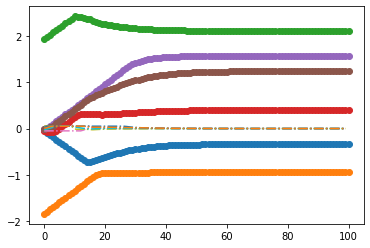

In [140]:
i_sim = 0
i_iter = 0
Q_all = np.array(Q_list)
Q_all_i = np.array([Q_all[i_iter, i_sim,:] for i_iter in range(len(Q_list))])
plt.plot(Q_all_i,'-o')
plt.plot(Q_all_i[1:,:]-Q_all_i[:-1,:],'-.')

In [ ]:
plt.plot(dist_list, label="distance")

In [ ]:
plt.plot(loss_list, label="total")
plt.plot(np.multiply(jl_loss_list, graph.alpha_jl), label="joint limit")
plt.plot(np.multiply(jc_loss_list, graph.alpha_jc), label="joint target")
plt.plot(np.multiply(fc_loss_list, graph.alpha_fc), label="frame target")
plt.plot(np.multiply(cl_loss_list, graph.alpha_cl), label="collision dist")
plt.legend()
axes = plt.gca()
# axes.set_ylim([-1e1,5e1])
# axes.set_xlim([0,1e1])

# Show rviz

In [293]:
q = Q_[0]
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q[2:-1]]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# Display motion

In [294]:
for i_sim in range(1): # N_sim):
    for i_iter in range(0,len(Q_list)):
        q = Q_list[i_iter][i_sim]
        gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
        pose_list = [q]
        gframevec_list = [gframevec]
        show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
        time.sleep(10e-2)

# Collision error case 

In [ ]:
Q_error = np.loadtxt("Q_error.csv",delimiter=",",dtype=np.float32)
graph.assign_Q(Q_error)
graph.assign_frame_dict(gframe_dict_list)

T_all, Tbo_all = graph(None)
dist = K.min(graph.test_collision(T_all, Tbo_all)[0]).numpy()
cl_loss = graph.calc_collision_loss(T_all, Tbo_all)
print("dist: {}".format(dist))

In [ ]:
q = Q_error[0]
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q[2:-1]]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# Plot 3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(1,1,1,projection="3d")
sub.plot(x,y,z)
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0., azim=0)